In [1]:
import pandas as pd
import seaborn as sbn
import numpy as np

In [2]:
data_url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv'

In [3]:
#!wget $data_url

--2021-09-19 12:09:31--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7077973 (6.8M) [text/plain]
Saving to: ‘AB_NYC_2019.csv’

AB_NYC_2019.csv     100%[===================>]   6.75M  7.32MB/s    in 0.9s    

2021-09-19 12:09:32 (7.32 MB/s) - ‘AB_NYC_2019.csv’ saved [7077973/7077973]



In [4]:
df = pd.read_csv('AB_NYC_2019.csv')

In [13]:
df.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


In [6]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [9]:
df.price.describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

<AxesSubplot:ylabel='Count'>

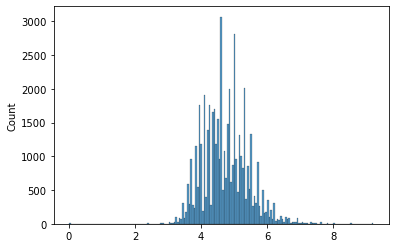

In [12]:
sbn.histplot(np.log1p(df.price.values))

In [14]:
base_columns = ['latitude',
'longitude',
'price',
'minimum_nights',
'number_of_reviews',
'reviews_per_month',
'calculated_host_listings_count',
'availability_365']

In [18]:
df = df[base_columns] # base columns selection

In [20]:
df.isnull().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [21]:
df.minimum_nights.describe()

count    48895.000000
mean         7.029962
std         20.510550
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

In [27]:
np.random.seed(42)
idx = np.arange(df.shape[0])
np.random.shuffle(idx)

In [29]:
n = df.shape[0]
n_train = int(0.6 * n)
n_val = int(0.2 * n)
n_test = n - n_val - n_train

In [30]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train: n_train + n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [31]:
df_train.shape[0] + df_val.shape[0] + df_test.shape[0] == n

True

In [34]:
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [35]:
y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

In [37]:
del df_train['price']
del df_val['price']
del df_test['price']

In [39]:
y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
y_test = np.log1p(y_test)

In [40]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    w_full = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    
    return w_full[0], w_full[1:] # base_term + weights

In [44]:
def rmse(y, y_train):
    return np.sqrt(((y - y_train)**2).mean())

In [60]:
def prepare_X(df):
    df = df.copy()
    df.reviews_per_month = df.reviews_per_month.fillna(0)
    return df.values

In [61]:
w0, w = train_linear_regression(prepare_X(df_train), y_train)

In [62]:
y_pred = w0 + prepare_X(df_val).dot(w)

In [64]:
round(rmse(y_pred, y_val), 2) # fill null with 0

0.64

In [65]:
mean_reviews_per_month = df_train.reviews_per_month.mean()

In [66]:
def prepare_X(df):
    df = df.copy()
    df.reviews_per_month = df.reviews_per_month.fillna(mean_reviews_per_month)
    return df.values

In [67]:
w0, w = train_linear_regression(prepare_X(df_train), y_train)
y_pred = w0 + prepare_X(df_val).dot(w)
round(rmse(y_pred, y_val), 2) # fill null with 0

0.64

In [74]:
def train_linear_regression_with_reg(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    w_full = np.linalg.inv(X.T.dot(X) + r*np.eye(X.shape[1])).dot(X.T).dot(y)
    
    return w_full[0], w_full[1:] # base_term + weights

In [75]:
def prepare_X(df):
    df = df.copy()
    df.reviews_per_month = df.reviews_per_month.fillna(0)
    return df.values

In [76]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w0, w = train_linear_regression_with_reg(prepare_X(df_train), y_train, r)
    y_pred = w0 + prepare_X(df_val).dot(w)
    print(r, round(rmse(y_pred, y_val), 2)) # fill null with 0

0 0.64
1e-06 0.64
0.0001 0.64
0.001 0.64
0.01 0.66
0.1 0.68
1 0.68
5 0.68
10 0.68


In [97]:
rmse_list = []
for seed in range(10):
    np.random.seed(seed)
    idx = np.arange(df.shape[0])
    np.random.shuffle(idx)
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train: n_train + n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]
    df_train = df_train.reset_index(drop = True)
    df_val = df_val.reset_index(drop = True)
    df_test = df_test.reset_index(drop = True)
    y_train = df_train.price.values
    y_val = df_val.price.values
    y_test = df_test.price.values
    del df_train['price']
    del df_val['price']
    del df_test['price']
    y_train = np.log1p(y_train)
    y_val = np.log1p(y_val)
    y_test = np.log1p(y_test)
    w0, w = train_linear_regression(prepare_X(df_train), y_train)
    y_pred = w0 + prepare_X(df_val).dot(w)
    rmse_list.append(rmse(y_pred, y_val))

In [98]:
round(np.std(rmse_list), 3)

0.008

In [81]:
rmse_list

[0.6549779961658987,
 0.6462523685602715,
 0.6476558177088931,
 0.6375145070618105,
 0.6445809083397473,
 0.6305809996462435,
 0.6297851915888546,
 0.6506184266349645,
 0.6489780353206073,
 0.6437565167963215]

In [85]:
np.random.seed(9)
idx = np.arange(df.shape[0])
np.random.shuffle(idx)
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train: n_train + n_val]]
df_test = df.iloc[idx[n_train+n_val:]]
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)
y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values
del df_train['price']
del df_val['price']
del df_test['price']
y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
y_test = np.log1p(y_test)

In [88]:
df_train_and_val = pd.concat([df_train, df_val])
df_train_and_val = df_train_and_val.reset_index(drop = True)

In [89]:
y_train_and_val = np.concatenate([y_train, y_val])

In [92]:
w0, w = train_linear_regression_with_reg(prepare_X(df_train_and_val), y_train_and_val, 0.001)

In [93]:
y_pred = w0 + prepare_X(df_test).dot(w)

In [94]:
rmse(y_test, y_pred)

0.6452771349036991

In [99]:
rmse(np.expm1(y_test), np.expm1(y_pred))

262.06970158770326